# Chapter 7 - Programming with Qiskit

In [1]:
!pip install qiskit==1.4.2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 34.7 MB/s eta 0:00:00
  Attempting uninstall: qiskit
    Found existing installation: qiskit 2.0.0
    Uninstalling qiskit-2.0.0:
      Successfully uninstalled qiskit-2.0.0


In [2]:
# Load helper file
from qiskit_ibm_runtime import QiskitRuntimeService

from google.colab import userdata

# README FIRST: UPDATE WITH YOUR TOKEN ID FIRST BEFORE RUNNING ANY CODE. TOKEN CAN BE FOUND IN YOUR ACCOUNT DETAILS ON THE IBM QUANTUM PLATFORM
myToken = userdata.get('ApiToken')
#Save an IBM Quantum account and set it as your default account.
QiskitRuntimeService.save_account(channel="ibm_quantum", token=myToken, set_as_default=True, overwrite=True)
# Import libraries and objects
from qiskit import QuantumCircuit, transpile
from qiskit_ibm_runtime import QiskitRuntimeService, SamplerV2 as Sampler
from qiskit_ibm_runtime import Options
from qiskit_ibm_runtime import Session
from qiskit.primitives import StatevectorSampler
from qiskit.providers.basic_provider import BasicSimulator
from qiskit.quantum_info import Statevector
from qiskit_ibm_runtime.fake_provider import FakeManilaV2
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.visualization import *


service = QiskitRuntimeService()
from qiskit import QuantumCircuit, ClassicalRegister
from qiskit.providers.fake_provider import GenericBackendV2

def create_circuit(num_qubits, add_measurements):

    # Create a circuit with classical control
    meas = ClassicalRegister(num_qubits)
    qc = QuantumCircuit(num_qubits)
    qc.add_register(meas)
    if add_measurements:
        for i in range(num_qubits):
            qc.measure(i, meas[i])

    # Define backend with custom basis gates
    #backend = GenericBackendV2(
     #   num_qubits=num_qubits,
     #   basis_gates=["ecr", "id", "rz", "sx", "x"],
     #   control_flow=True,
    #)

    return qc
# Run a Statevector simulator:
def run_sv_simulator(qc):
    from qiskit.quantum_info import Statevector
    statevector = Statevector(qc)
    return statevector
# Run a Unitary simulator:
def run_unitary_simulator(qc):
    from qiskit.quantum_info import Operator
    result = Operator(qc).data
    return result
# Run a QASM simulator:
def run_qasm_simulator(qc):
    from qiskit.providers.basic_provider import BasicSimulator
    backend = BasicSimulator()
    result = backend.run(qc).result()
    return result
# Execute circuit on the the State vector sampler
def run_sv_circuit(qc):
    # Run the circuit and return the state vector object result
    stateVectorResult = Statevector(qc)
    #qsphere = stateVectorResult.draw('qsphere')
    #bloch_sphere = stateVectorResult.draw('bloch')
    #circuit_image = qc.draw(output='mpl')
    return stateVectorResult

# Execute circuit on the Basic Aer qasm simulator, RENAMED from run_qasm_circuit to run_simulated_circuit
def run_simulated_circuit(qc, backend, options):
    #Check if option object is set
    if options == None:
        options = Options(optimization_level=3)

    #Check if backend is defined
    if backend == None:
        backend = BasicSimulator()

    transpiled_qc = transpile(qc, backend)
    result = backend.run(transpiled_qc).result()

    return transpiled_qc, result
# Execute circuit on the Basic Aer qasm simulator
def simulate_on_sampler(qc, backend, options):

    # Construct an ideal simulator with Sampler
    from qiskit.primitives import StatevectorSampler
    sampler = StatevectorSampler()

    # Transpile circuit
    pm = generate_preset_pass_manager(optimization_level=1)
    transpiled_qc = pm.run(qc)

    # Run using sampler
    state_vector_result = sampler.run([qc])

    result = state_vector_result.result()

    return transpiled_qc, result, state_vector_result
# Execute a circuit on a real backend - Sampler
def execute_circuit(qc, simulator, service, backend, options):
    # If executing on a qasm simulator
    if simulator:
        return run_qasm_circuit(qc, backend, options)

    if options == None:
        options = Options(optimization_level=3)

    with Session(service=service, backend=backend) as session:
        # Submit a request to the Sampler primitive within the session.
        sampler = Sampler(session=session, options=options)
        job = sampler.run(circuits=qc)
        result = job.result()
        return result
# Will run the circuit on the state vector (sv) simulator
# Returns state vector results, circuit diagram, Sphere & Bloch sphere
def execute_circuit_sv(quantum_circuit):
    stateVectorResults = run_sv_circuit(quantum_circuit)

    #Draw the circuit diagram
    circuit_diagram = quantum_circuit.draw(output="mpl")
    #Draw the Qsphere
    q_sphere = stateVectorResults.draw('qsphere')
    #Draw the Bloch sphere
    bloch_sphere = stateVectorResults.draw('bloch')
    #Return the results, circuit diagram, and QSphere
    return stateVectorResults, circuit_diagram, q_sphere, bloch_sphere
# Will execute the circuit on the qasm simulator
# Returns results, circuit diagram, and histogram
def execute_circuit_returns(quantum_circuit):
    from qiskit.primitives import Sampler
    sampler = Sampler()

    result = sampler.run(quantum_circuit, shots=1024).result()
    quasi_dists = result.quasi_dists

    # Convert the output to bit strings
    counts = quasi_dists[0].binary_probabilities()

    #Draw the circuit diagram
    circuit_diagram = quantum_circuit.draw(output="mpl")
    #Create a histogram of the counts
    histogram = plot_distribution(counts)
    #Return the results, circuit diagram, and histogram
    return counts, circuit_diagram, histogram
# Will execute the circuit on the qasm simulator
# Returns results, circuit diagram, and histogram
def execute_param_circuit(quantum_circuit, params):
    from qiskit.primitives import Sampler
    sampler = Sampler()

    result = sampler.run(quantum_circuit, shots=1024).result()
    quasi_dists = result.quasi_dists

    # Convert the output to bit strings
    counts = quasi_dists[0].binary_probabilities()

    circuit_diagram = quantum_circuit.draw(output="mpl")
    #Create a histogram of the counts
    histogram = plot_distribution(counts)
    #Return the results, circuit diagram, and histogram
    return counts, circuit_diagram, histogram
#Flag to set to run test cell below, simply change Flase to True:
test = True
if test:
    import qiskit
    from qiskit.primitives import StatevectorSampler

    # Construct an ideal simulator with SamplerV2
    sampler = StatevectorSampler()

    # Generate 3-qubit GHZ state
    circuit = qiskit.QuantumCircuit(3)
    circuit.h(0)
    circuit.cx(0, 1)
    circuit.cx(1, 2)
    circuit.measure_all()


    # Transpile circuit
    pm = generate_preset_pass_manager(optimization_level=1)
    isa_circuit = pm.run(circuit)

    # Run using sampler
    result = sampler.run([circuit]).result()

    # Access result data for PUB 0
    data_pub = result[0].data

    # Access bitstring for the classical register "meas"
    bitstrings = data_pub.meas.get_bitstrings()
    print(f"The number of bitstrings is: {len(bitstrings)}")

    # Get counts for the classical register "meas"
    counts = data_pub.meas.get_counts()
    print(f"The counts are: {counts}")

<ipython-input-2-5c9047bc0d8e>:21: DeprecationWarning: The "ibm_quantum" channel option is deprecated and will be sunset on 1 July. After this date, ibm_cloud will be the only valid channel. For information on migrating to the new IBM Quantum Platform on the "ibm_cloud" channel, review the migration guide https://quantum.cloud.ibm.com/docs/migration-guides/classic-iqp-to-cloud-iqp .
  service = QiskitRuntimeService()


The number of bitstrings is: 1024
The counts are: {'111': 520, '000': 504}


In [3]:
# Load helper file
# %run helper_file_1.0.ipynb

qc = QuantumCircuit(2,2)

In [4]:
!pip install pylatexenc

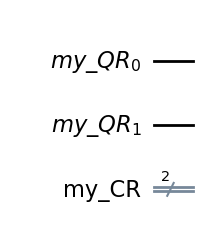

In [5]:
# Import registers
from qiskit import QuantumRegister, ClassicalRegister

qr = QuantumRegister(2, 'my_QR')
cr = ClassicalRegister(2, 'my_CR')
qc = QuantumCircuit(qr,cr)
qc.draw(output='mpl')


In [6]:
qc = QuantumCircuit(QuantumRegister(2, 'my_QR'), ClassicalRegister(2, 'my_CR'))

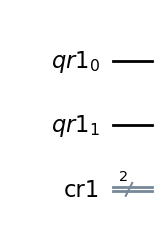

In [7]:
#Create the quantum and classical registers, each with labels
qr1 = QuantumRegister(2, name='qr1')
cr1 = ClassicalRegister(2, name='cr1')
#Create the quantum circuit using the registers
qc1 = QuantumCircuit(qr1, cr1)
#Draw the circuit
qc1.draw(output='mpl')


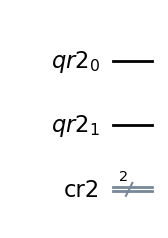

In [8]:
#Create two Quantum and Classical registers
qr2 = QuantumRegister(2, name='qr2')
cr2 = ClassicalRegister(2, name='cr2')
#Create a second circuit using the registers created above
qc2 = QuantumCircuit(qr2, cr2)
#Draw the second quantum circuit
qc2.draw(output='mpl')


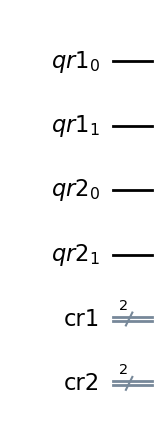

In [9]:
#Concatenate the two previous circuits to create a new circuit
#Create an empty quantum circuit
qc_combined = QuantumCircuit()
#Add the two previous quantum and classical registers to the empty quantum circuit
qc_combined.add_register(qr1, qr2, cr1, cr2)
#Draw the concatenated circuit
qc_combined.draw(output='mpl')


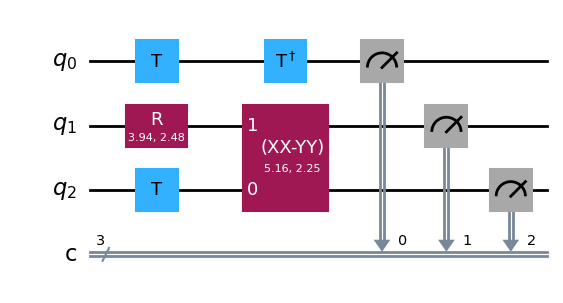

In [10]:
#Import the random_circuit class
from qiskit.circuit.random import random_circuit
#Construct the random circuit with the number of qubits = 3
#with a depth = 2, and include the measurement operator for each qubit
qc = random_circuit(3, 2, measure=True)
#Draw the circuit
qc.draw(output='mpl')


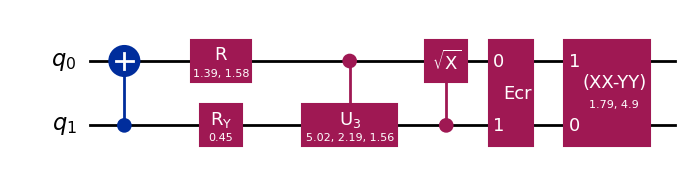

In [11]:
# Import the random circuit class
from qiskit.circuit.random import random_circuit
#Create two random circuits, each with 2 qubit registers and random #gate operator counts.
qc1 = random_circuit(2,2)
qc2 = random_circuit(2,4)
#Concatenate the two random circuits
qc = qc1.compose(qc2, [0,1])
#Draw the circuit
qc.draw(output='mpl')


In [12]:
#Define function to print circuit properties:
def print_circuit_props(qc):
    width = qc.width()
    depth = qc.depth()
    num_operators = qc.count_ops()
    circuit_size = qc.size()
    print('Width = ', width)
    print('Depth = ', depth)
    print('Circuit size = ', circuit_size)
    print('Number of operators = ', num_operators)


In [13]:
#Pass our quantum circuit to print out the circuit properties
print_circuit_props(qc)


Width =  2
Depth =  6
Circuit size =  7
Number of operators =  OrderedDict([('cx', 1), ('ry', 1), ('r', 1), ('cu3', 1), ('csx', 1), ('ecr', 1), ('xx_minus_yy', 1)])


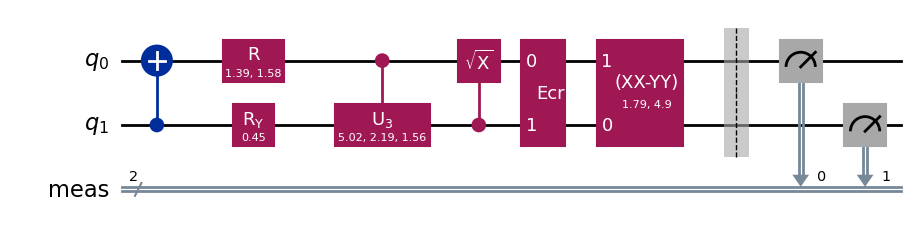

In [14]:
#Use measure_all() to automatically add the barrier, measurement, and #classical register to our existing circuit.
qc.measure_all()
#Draw the circuit
qc.draw(output='mpl')


In [15]:
#Print out the circuit properties
print_circuit_props(qc)

Width =  4
Depth =  7
Circuit size =  9
Number of operators =  OrderedDict([('measure', 2), ('cx', 1), ('ry', 1), ('r', 1), ('cu3', 1), ('csx', 1), ('ecr', 1), ('xx_minus_yy', 1), ('barrier', 1)])


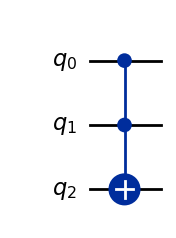

In [16]:
qc = QuantumCircuit(3)
qc.ccx(0,1,2)
qc.draw(output='mpl')


In [17]:
#Print out the circuit properties
print_circuit_props(qc)


Width =  3
Depth =  1
Circuit size =  1
Number of operators =  OrderedDict([('ccx', 1)])


Width =  3
Depth =  11
Circuit size =  15
Number of operators =  OrderedDict([('cx', 6), ('t', 4), ('tdg', 3), ('h', 2)])


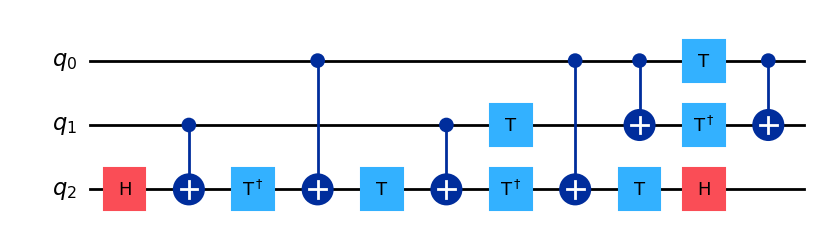

In [18]:
#Print out the circuit properties
print_circuit_props(qc.decompose())
qc.decompose().draw(output='mpl')

# Customization and Parameterization of circuits

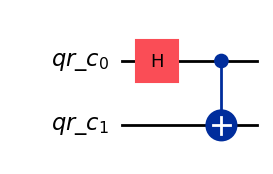

In [19]:
#Create a custom two-qubit composite gate
#Create the quantum register
qr = QuantumRegister(2, name='qr_c')
#Generate quantum circuit which will make up the composite gate
comp_qc = QuantumCircuit(qr, name='My-composite')
#Add any gates you wish to your composite gate
comp_qc.h(0)
comp_qc.cx(0, 1)
#Create the composite instructions by converting
#the QuantumCircuit to a list of Instructions
composite_inst = comp_qc.to_instruction()
#Draw the circuit which will represent the composite gate
comp_qc.draw(output='mpl')


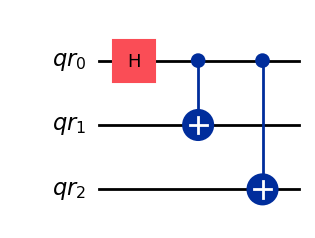

In [20]:
#Create your 2-qubit circuit to generate your composite gate
qr2 = QuantumRegister(3, 'qr')
#Create a quantum circuit using the quantum register
qc = QuantumCircuit(qr2)
#Add any arbitrary gates that would represent the function
#of the composite gate
qc.h(0)
qc.cx(0,1)
qc.cx(0,2)
#Draw the composite circuit
qc.draw(output='mpl')


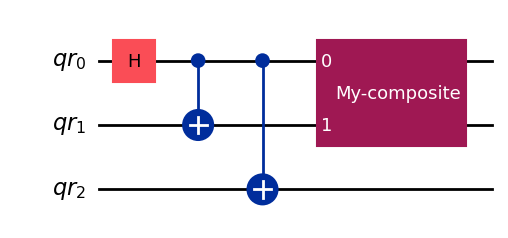

In [21]:
#Append your composite gate to the specified qubits.
qc.append(composite_inst, [qr2[0], qr2[1]])
#Draw the complete circuit
qc.draw(output='mpl')


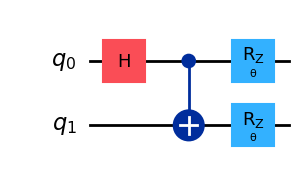

In [22]:
#Import the Parameter object
from qiskit.circuit import Parameter
#Construct the Parameter set to Theta
param_theta = Parameter('θ')
#Create a two-qubit quantum circuit and add some gates
qc = QuantumCircuit(2)
qc.h(0)
qc.cx(0, 1)
#Include a rotation gate which we wish to apply
#the Parameter value
qc.rz(param_theta,0)
qc.rz(param_theta,1)
#Draw the circuit
qc.draw(output='mpl')


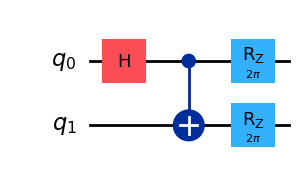

In [23]:
import numpy as np
#Bind the parameters with a value, in this case 2π
qc = qc.assign_parameters(parameters={param_theta: 2*np.pi})
#Draw the circuit with the set parameter values
qc.draw(output='mpl')


# Generating Pulse schedules on quantum hardware

In [24]:
#Import pulse classes
from qiskit.pulse import Waveform, DriveChannel, Play, Schedule


<ipython-input-25-2bb93701a0a5>:6: DeprecationWarning: The class ``qiskit.pulse.library.waveform.Waveform`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  waveform = Waveform(data, name="sin_64_pulse")


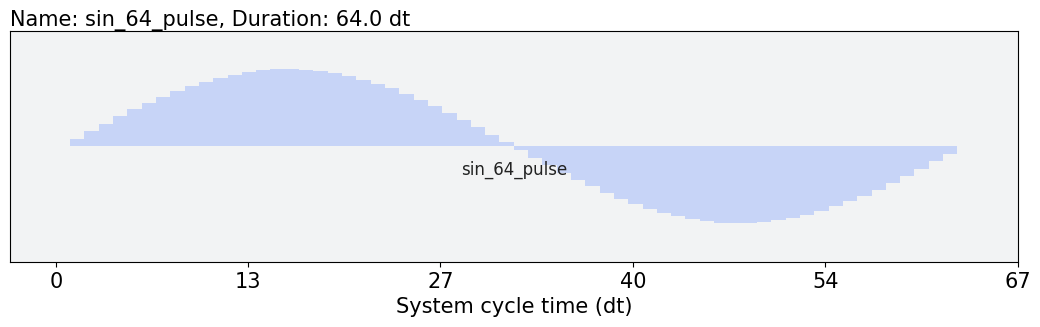

In [25]:
#Import numpy and generate the sin sample values
import numpy as np
x = np.linspace(0,2*np.pi,64)
data = np.sin(x)
#Generate our sample waveform
waveform = Waveform(data, name="sin_64_pulse")
#Draw the generated sample waveform
waveform.draw()


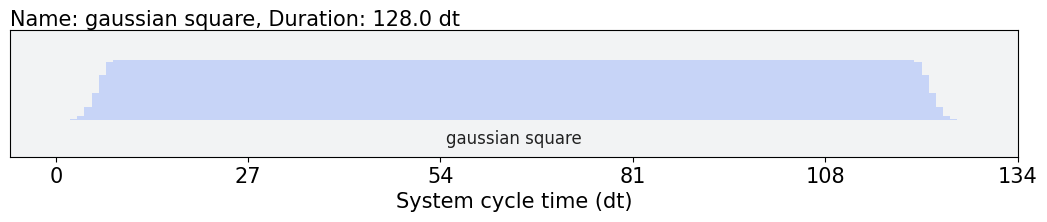

In [26]:
#Import the Gaussian Square pulse from Pulse Library
from qiskit.pulse.library import GaussianSquare
#Create a Gaussian Square pulse:
#Args: duration, amp, sigma, width, name
gaussian_square_pulse = GaussianSquare(128,1,2,112, name="gaussian square")
gaussian_square_pulse.draw()


# Generating and executing Schedules

<ipython-input-27-368323949047>:2: DeprecationWarning: The class ``qiskit.pulse.schedule.Schedule`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  schedule_1 = Schedule(name='Schedule 1')
<ipython-input-27-368323949047>:3: DeprecationWarning: The class ``qiskit.pulse.channels.Channel`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  schedule_1 = schedule_1.insert(0, Play(gaussian_square_pulse, DriveChannel(0)))
<ipython-input-27-368323949047>:3: DeprecationWarning: The class ``qiskit.pulse.instructions.play.Play`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and wil

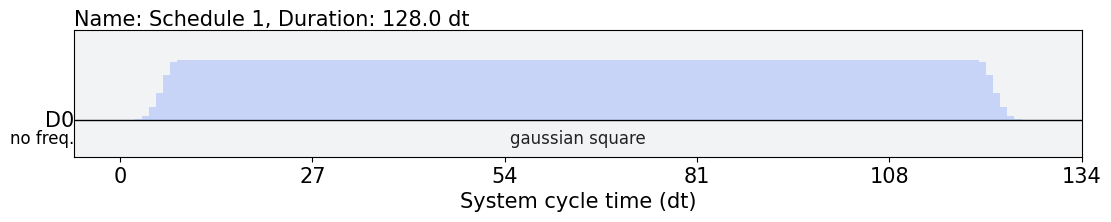

In [27]:
#Create the first schedule with our Gaussian Square pulse
schedule_1 = Schedule(name='Schedule 1')
schedule_1 = schedule_1.insert(0, Play(gaussian_square_pulse, DriveChannel(0)))
#Draw the schedule
schedule_1.draw()


<ipython-input-28-c6710bee1c9c>:2: DeprecationWarning: The class ``qiskit.pulse.schedule.Schedule`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  schedule_2 = Schedule(name='Schedule 2')
<ipython-input-28-c6710bee1c9c>:3: DeprecationWarning: The class ``qiskit.pulse.channels.Channel`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  schedule_2 = schedule_2.insert(0, Play(waveform, DriveChannel(0)))
<ipython-input-28-c6710bee1c9c>:3: DeprecationWarning: The class ``qiskit.pulse.instructions.play.Play`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to

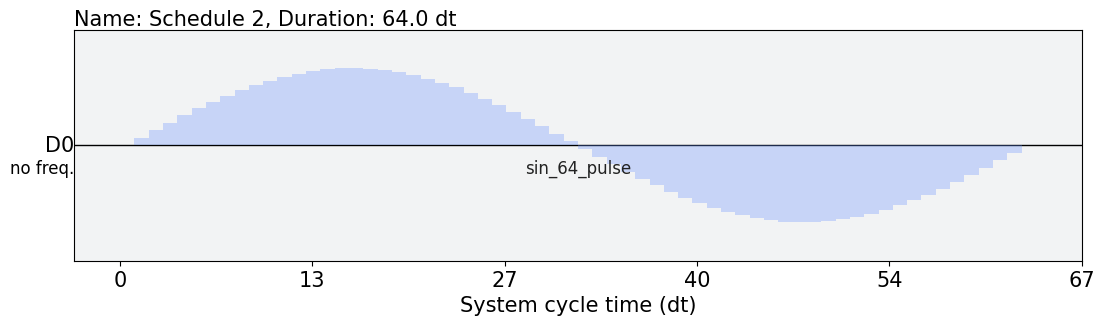

In [28]:
#Create a second schedule with our sample waveform
schedule_2 = Schedule(name='Schedule 2')
schedule_2 = schedule_2.insert(0, Play(waveform, DriveChannel(0)))
#Draw the schedule
schedule_2.draw()


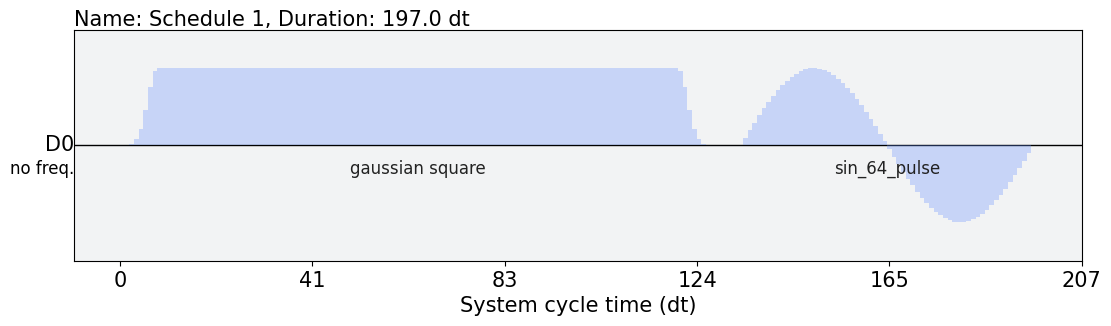

In [29]:
#Let's create a third schedule
#Where we add the first schedule and second schedules
#And shift the second to the right by a time of 5 after the first
schedule_3 = schedule_1.insert(schedule_1.duration+5, schedule_2)
schedule_3.draw()


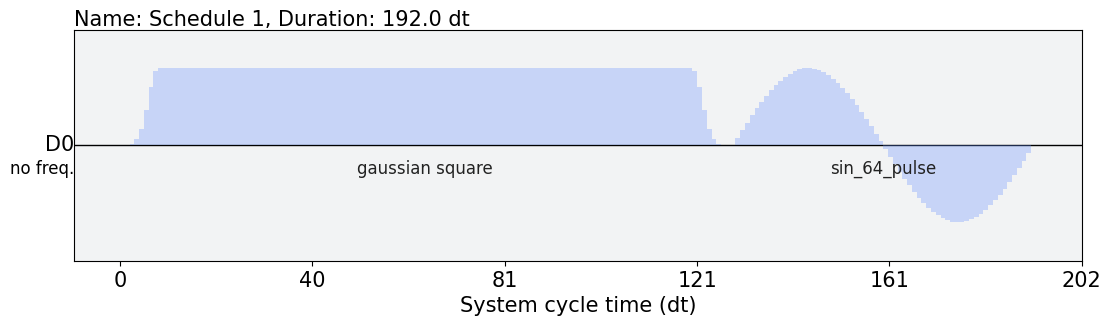

In [30]:
#We could have also combined the two using the append operator
#The two schedules are appended immediately after one another
schedule_3_append = schedule_1.append(schedule_2)
schedule_3_append.draw()


# Understanding the Job component

In [31]:
# Run the simple quantum circuit on local Sampler
from qiskit.primitives import Sampler
sampler = Sampler()

# Create a simple circuit
qc = QuantumCircuit(1,1)
qc.h(0)
qc.measure([0],[0])

# Run the qc circuit
job = sampler.run(qc, shots=1024)
print(job.status())

JobStatus.RUNNING


<ipython-input-31-258f95db6eda>:3: DeprecationWarning: The class ``qiskit.primitives.sampler.Sampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Sampler` class is `StatevectorSampler`.
  sampler = Sampler()


In [32]:
#From the previous output of executed jobs, obtain the job id
#and print out information about the Job.
print('Print Job ID: ', job.job_id())
print('Print Job Status: ', job.status())
print('Print Job Result: ', job.result())

Print Job ID:  415ce2cd-6d43-4c27-9915-9d0fc66b3ce2
Print Job Status:  JobStatus.RUNNING
Print Job Result:  SamplerResult(quasi_dists=[{0: np.float64(0.529296875), 1: np.float64(0.470703125)}], metadata=[{'shots': 1024}])


{'0': np.float64(0.529296875), '1': np.float64(0.470703125)}


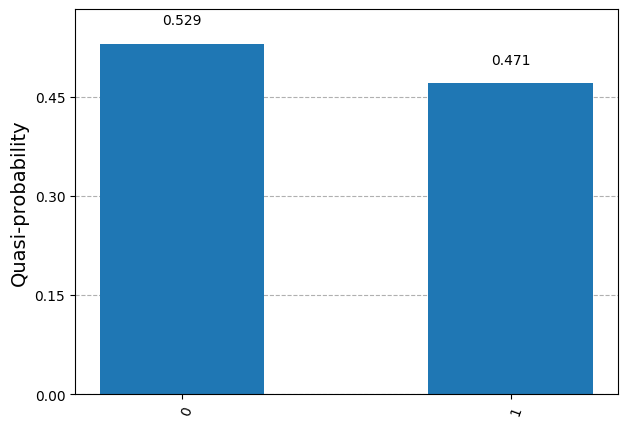

In [33]:
job_result = job.result()

quasi_dists = job_result.quasi_dists

#Get the result counts
counts = quasi_dists[0].binary_probabilities()

print(counts)
plot_distribution(counts)
